In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor


In [2]:
train=pd.read_csv('C:/Comp1/train.csv')
test=pd.read_csv('C:/Comp1/test.csv')

In [3]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [4]:
train.head()


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

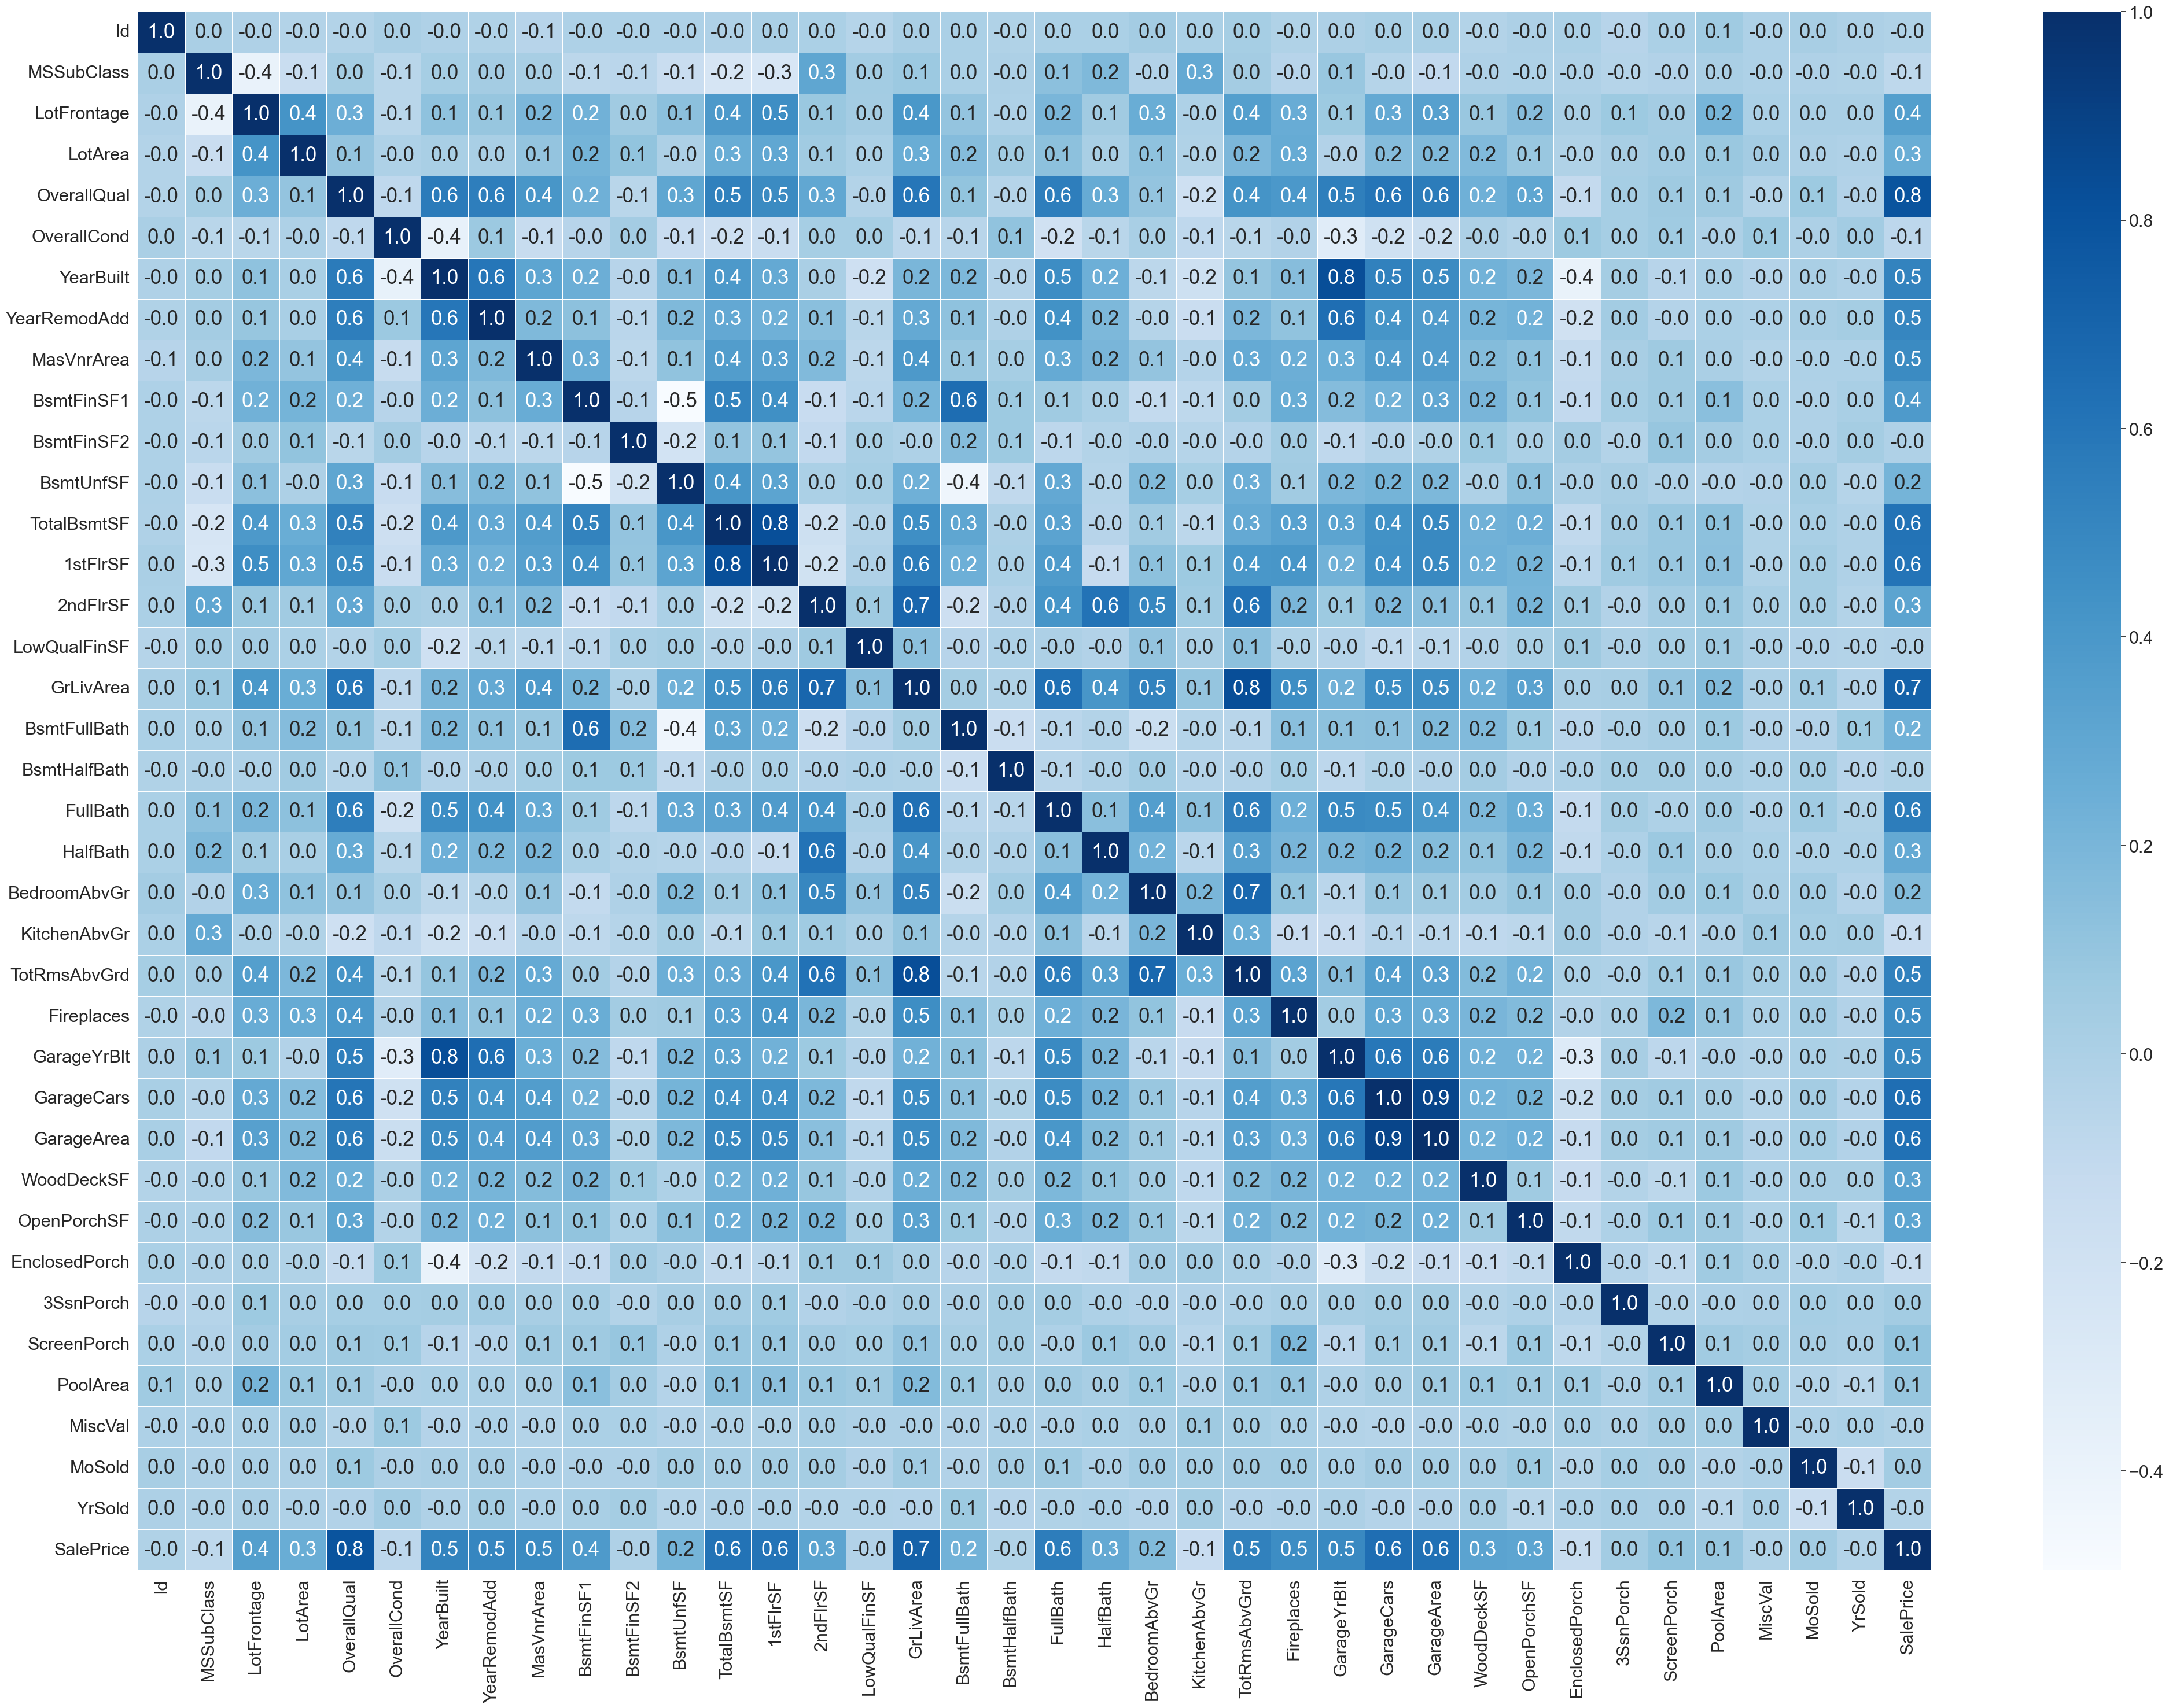

In [5]:
correlation_train=train.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='Blues', linewidths=.5)

In [6]:
corr_dict=correlation_train['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'HalfBath',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'EnclosedPorch',
 'KitchenAbvGr']

C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.3% of the points c

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

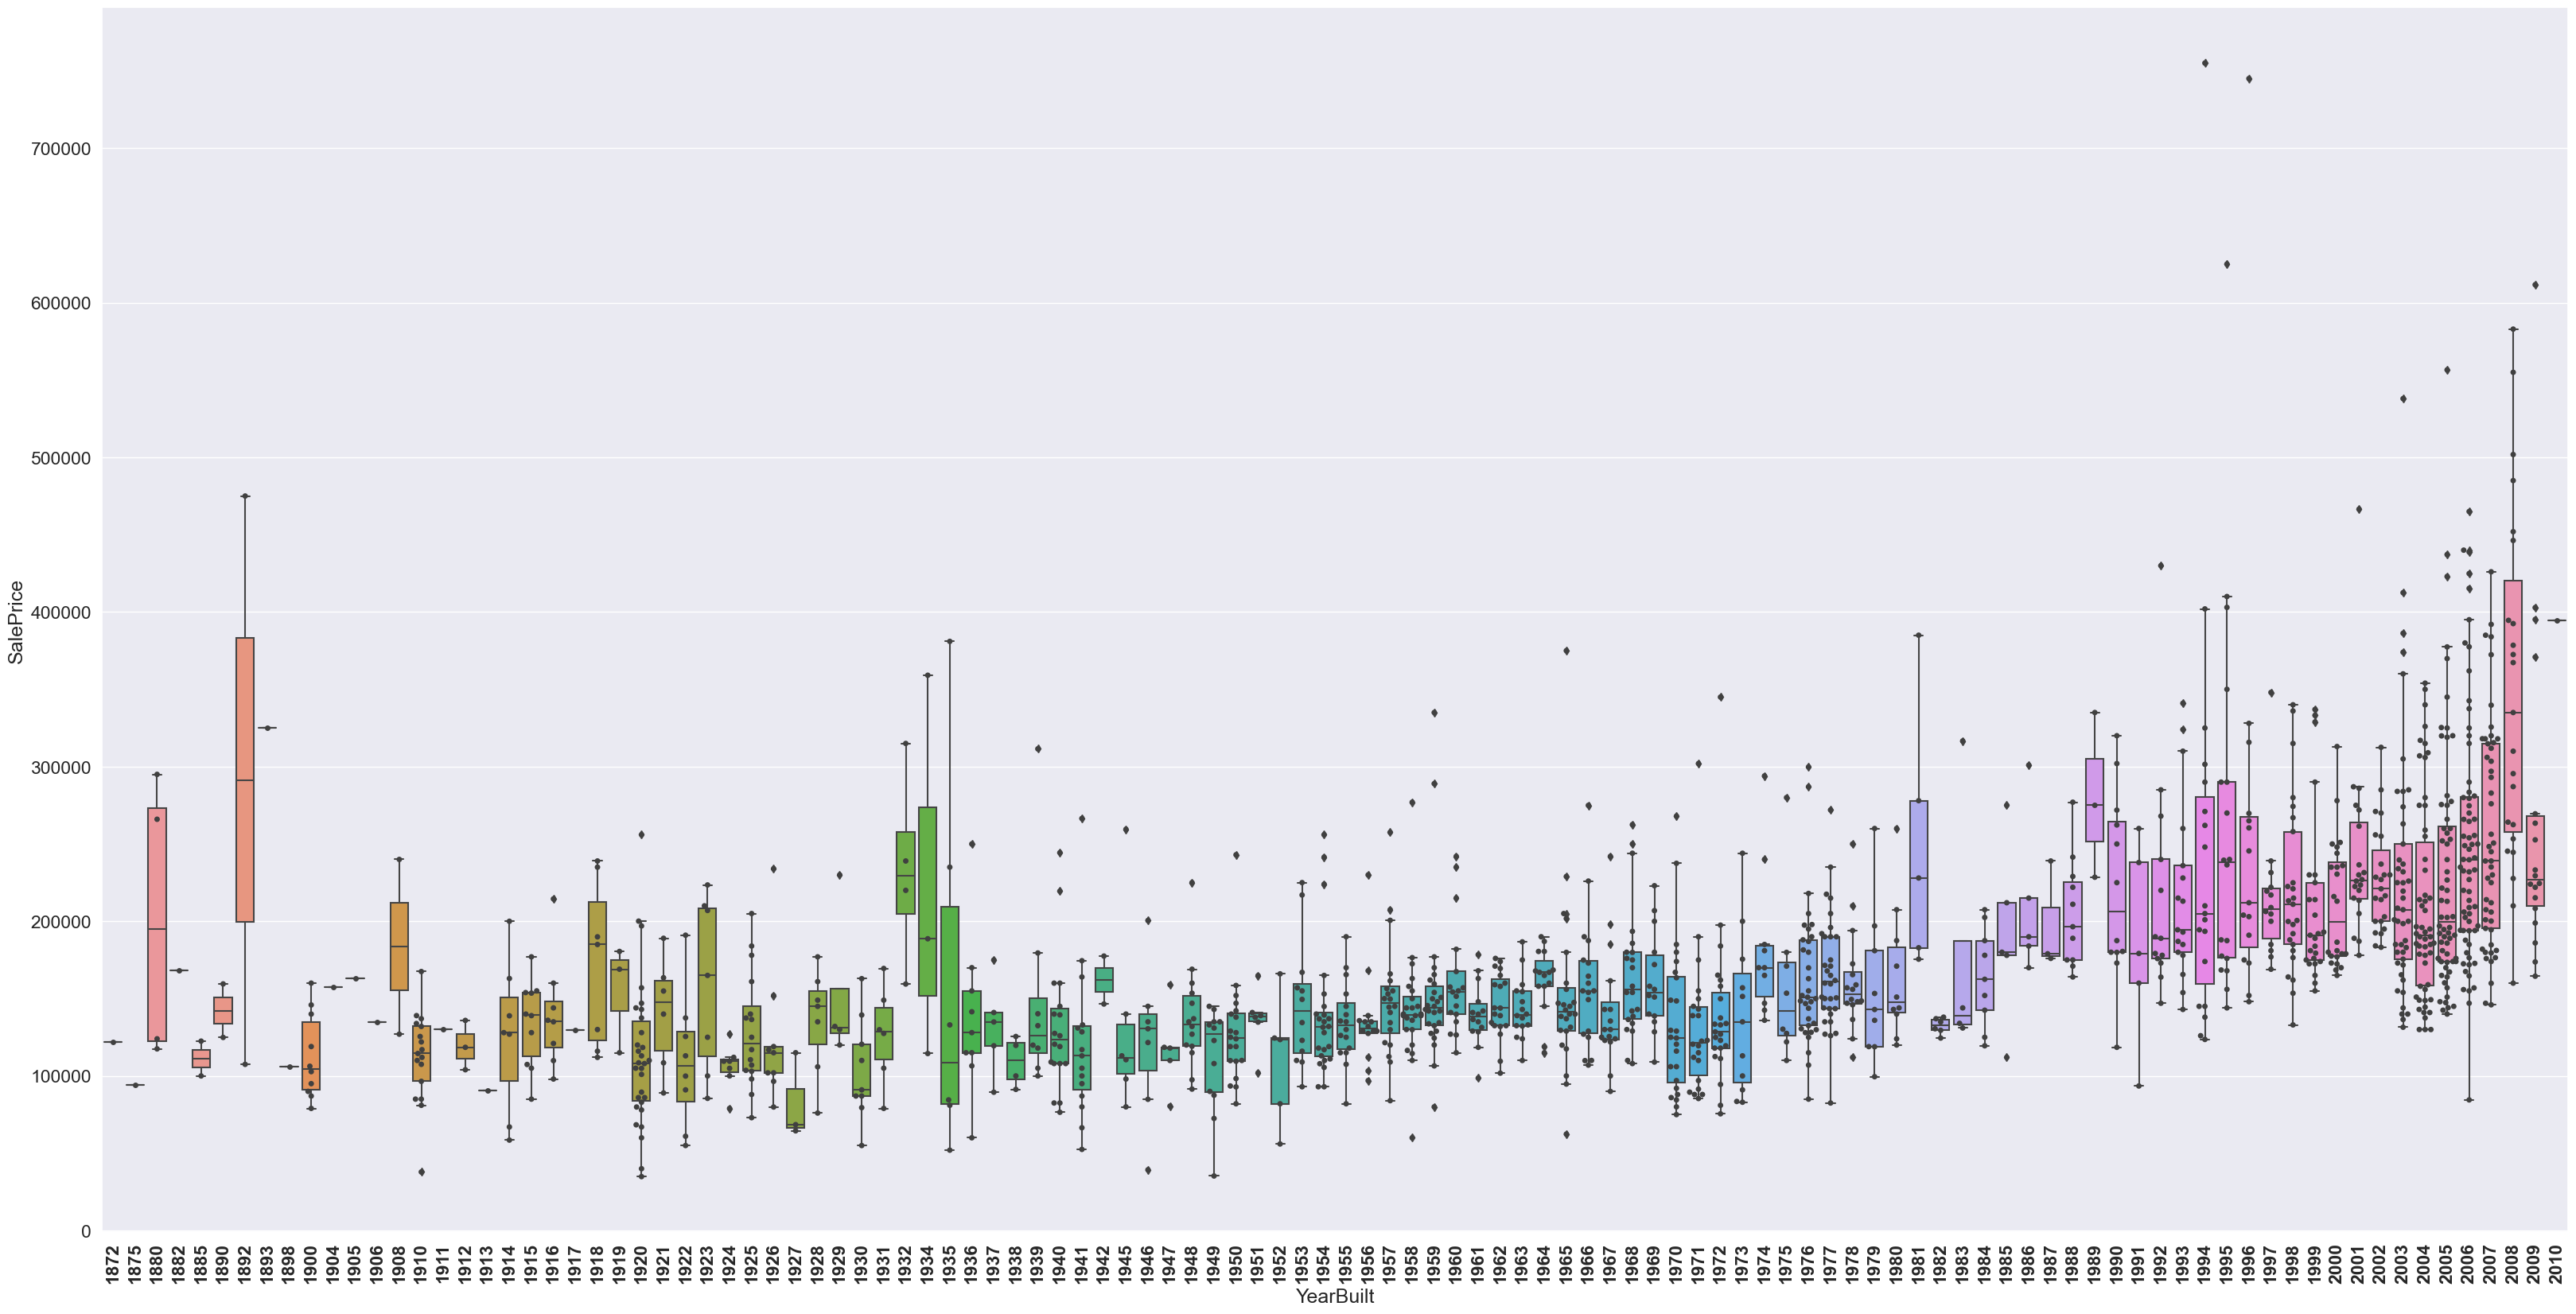

In [7]:
plt.figure(figsize=(40,20))
sb.set(font_scale=1.5)
sb.boxplot(x='YearBuilt', y="SalePrice", data=train)
sb.swarmplot(x='YearBuilt', y="SalePrice", data=train, color=".25")
plt.xticks(weight='bold',rotation=90)

In [8]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [9]:
train_test=pd.concat([train,test],axis=0,sort=False)
train_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal   208500.0  
1   2007        WD         Normal   181500.0  
2   2008        WD         Normal   223500.0  
3   2006        WD        Abnorml   140000.0  
4   2008        WD         Normal   250000.0  

[5 rows x 81 columns]

In [10]:
pd.set_option('display.max_rows', 5000)
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_tes_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_tes_info

Count of NaN DataTypes
Id                        0     int64
MSSubClass                0     int64
MSZoning                  4    object
LotFrontage             486   float64
LotArea                   0     int64
Street                    0    object
Alley                  2721    object
LotShape                  0    object
LandContour               0    object
Utilities                 2    object
LotConfig                 0    object
LandSlope                 0    object
Neighborhood              0    object
Condition1                0    object
Condition2                0    object
BldgType                  0    object
HouseStyle                0    object
OverallQual               0     int64
OverallCond               0     int64
YearBuilt                 0     int64
YearRemodAdd              0     int64
RoofStyle                 0    object
RoofMatl                  0    object
Exterior1st               1    object
Exterior2nd               1    object
MasVnrType               24    object
MasVnrArea               23   float64
ExterQual                 0    object
ExterCond                 0    object
Foundation                0    object
BsmtQual                 81    object
BsmtCond                 82    object
BsmtExposure             82    object
BsmtFinType1             79    object
BsmtFinSF1                1   float64
BsmtFinType2             80    object
BsmtFinSF2                1   float64
BsmtUnfSF                 1   float64
TotalBsmtSF               1   float64
Heating                   0    object
HeatingQC                 0    object
CentralAir                0    object
Electrical                1    object
1stFlrSF                  0     int64
2ndFlrSF                  0     int64
LowQualFinSF              0     int64
GrLivArea                 0     int64
BsmtFullBath              2   float64
BsmtHalfBath              2   float64
FullBath                  0     int64
HalfBath                  0     int64
BedroomAbvGr              0     int64
KitchenAbvGr              0     int64
KitchenQual               1    object
TotRmsAbvGrd              0     int64
Functional                2    object
Fireplaces                0     int64
FireplaceQu            1420    object
GarageType              157    object
GarageYrBlt             159   float64
GarageFinish            159    object
GarageCars                1   float64
GarageArea                1   float64
GarageQual              159    object
GarageCond              159    object
PavedDrive                0    object
WoodDeckSF                0     int64
OpenPorchSF               0     int64
EnclosedPorch             0     int64
3SsnPorch                 0     int64
ScreenPorch               0     int64
PoolArea                  0     int64
PoolQC                 2909    object
Fence                  2348    object
MiscFeature            2814    object
MiscVal                   0     int64
MoSold                    0     int64
YrSold                    0     int64
SaleType                  1    object
SaleCondition             0    object
SalePrice              1459   float64

In [11]:
train_test.loc[train_test['Fireplaces']==0,'FireplaceQu']='Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear',inplace=True)
train_test['LotFrontage']=train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear',inplace=True)
train_test['MasVnrArea']=train_test['MasVnrArea'].astype(int)
train_test["Fence"] = train_test["Fence"].fillna("None")
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None")
train_test.loc[train_test['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
train_test.loc[train_test['BsmtFinSF2']==0,'BsmtQual']='TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

for i in train_test.columns:
    if 'SalePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)]=train_test[str(i)].fillna(method='ffill')

In [12]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

In [13]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

MiscVal              21.947195
PoolArea             16.898328
exists_pool          14.884318
LotArea              12.822431
LowQualFinSF         12.088761
3SsnPorch            11.376065
LandSlope             4.975157
KitchenAbvGr          4.302254
EnclosedPorch         4.003891
ScreenPorch           3.946694
MasVnrArea            2.600375
OpenPorchSF           2.535114
WoodDeckSF            1.842433
LotFrontage           1.483631
1stFlrSF              1.469604
Total_Porch_Area      1.376649
GrLivArea             1.269358
2ndFlrSF              0.861675
TotRmsAbvGrd          0.758367
MSSubClass            0.738722
Fireplaces            0.733495
HalfBath              0.694566
OverallCond           0.570312
HeatingQC             0.486656
FireplaceQu           0.333787
BedroomAbvGr          0.326324
OverallQual           0.197110
MoSold                0.195884
FullBath              0.167606
YrSold                0.132399
Id                    0.000000
exists_fireplace     -0.054148
BsmtFinT

In [14]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [15]:

print('\nVariables with high skewness: \n\n',skewed_features)


Variables with high skewness: 

 Index(['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF',
       '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage',
       '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive',
       'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street',
       'PoolQC'],
      dtype='object')


In [16]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

MiscVal  PoolArea  exists_pool  LotArea  LowQualFinSF  3SsnPorch  \
0        0         0            0     8450             0          0   
1        0         0            0     9600             0          0   
2        0         0            0    11250             0          0   
3        0         0            0     9550             0          0   
4        0         0            0    14260             0          0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  ...  BsmtFinType2  \
0          0             1              0            0  ...             5   
1          0             1              0            0  ...             5   
2          0             1              0            0  ...             5   
3          0             1            272            0  ...             5   
4          0             1              0            0  ...             5   

   CentralAir  GarageQual  exists_garage  Functional  GarageCond  exists_bsmt  \
0           1           4              1           6           4            1   
1           1           4              1           6           4            1   
2           1           4              1           6           4            1   
3           1           4              1           6           4            1   
4           1           4              1           6           4            1   

   BsmtQual  Street  PoolQC  
0         3       1       3  
1         3       1       3  
2         3       1       3  
3         3       1       3  
4         3       1       3  

[5 rows x 34 columns]

In [17]:
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))

C:\Users\bhavy\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\bhavy\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [18]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

MiscVal  PoolArea  exists_pool    LotArea  LowQualFinSF  3SsnPorch  \
0      0.0       0.0          0.0  13.424522           0.0        0.0   
1      0.0       0.0          0.0  13.694529           0.0        0.0   
2      0.0       0.0          0.0  14.034135           0.0        0.0   
3      0.0       0.0          0.0  13.683423           0.0        0.0   
4      0.0       0.0          0.0  14.550144           0.0        0.0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  ...  BsmtFinType2  \
0        0.0       0.75096       0.000000          0.0  ...   1444.254405   
1        0.0       0.75096       0.000000          0.0  ...   1444.254405   
2        0.0       0.75096       0.000000          0.0  ...   1444.254405   
3        0.0       0.75096      16.012022          0.0  ...   1444.254405   
4        0.0       0.75096       0.000000          0.0  ...   1444.254405   

   CentralAir  GarageQual  exists_garage  Functional   GarageCond  \
0   11.792649   23.440983      14.969018   30.830925  2952.377899   
1   11.792649   23.440983      14.969018   30.830925  2952.377899   
2   11.792649   23.440983      14.969018   30.830925  2952.377899   
3   11.792649   23.440983      14.969018   30.830925  2952.377899   
4   11.792649   23.440983      14.969018   30.830925  2952.377899   

   exists_bsmt   BsmtQual    Street       PoolQC  
0     1.002985  54.556655  0.666716  3975.460276  
1     1.002985  54.556655  0.666716  3975.460276  
2     1.002985  54.556655  0.666716  3975.460276  
3     1.002985  54.556655  0.666716  3975.460276  
4     1.002985  54.556655  0.666716  3975.460276  

[5 rows x 34 columns]

In [19]:
train_test=pd.get_dummies(train_test,dtype='int8')

train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataType'])
train_test_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_test_info

NaN DataType
Id                        0    int64
MSSubClass                0    int64
LotFrontage               0  float64
LotArea                   0  float64
Street                    0  float64
Alley                     0    int32
LotShape                  0    int32
LandSlope                 0  float64
OverallQual               0    int64
OverallCond               0    int64
YearBuilt                 0    int64
YearRemodAdd              0    int64
MasVnrArea                0  float64
ExterQual                 0  float64
ExterCond                 0  float64
BsmtQual                  0  float64
BsmtCond                  0  float64
BsmtExposure              0  float64
BsmtFinType1              0    int32
BsmtFinSF1                1  float64
BsmtFinType2              0  float64
BsmtFinSF2                1  float64
BsmtUnfSF                 1  float64
TotalBsmtSF               1  float64
HeatingQC                 0    int32
CentralAir                0  float64
1stFlrSF                  0  float64
2ndFlrSF                  0    int64
LowQualFinSF              0  float64
GrLivArea                 0  float64
BsmtFullBath              2  float64
BsmtHalfBath              2  float64
FullBath                  0    int64
HalfBath                  0    int64
BedroomAbvGr              0    int64
KitchenAbvGr              0  float64
KitchenQual               0  float64
TotRmsAbvGrd              0    int64
Functional                0  float64
Fireplaces                0    int64
FireplaceQu               0    int32
GarageYrBlt             159  float64
GarageFinish              0    int32
GarageCars                1  float64
GarageArea                1  float64
GarageQual                0  float64
GarageCond                0  float64
PavedDrive                0  float64
WoodDeckSF                0  float64
OpenPorchSF               0  float64
EnclosedPorch             0  float64
3SsnPorch                 0  float64
ScreenPorch               0  float64
PoolArea                  0  float64
PoolQC                    0  float64
Fence                     0  float64
MiscVal                   0  float64
MoSold                    0    int64
YrSold                    0    int64
SalePrice              1459  float64
YrBltRmd                  0    int64
Total_Square_Feet         1  float64
Total_Bath                2  float64
Total_Porch_Area          0  float64
exists_pool               0  float64
exists_garage             0  float64
exists_fireplace          0    int64
exists_bsmt               0  float64
old_house                 0    int64
MSZoning_C (all)          0     int8
MSZoning_FV               0     int8
MSZoning_RH               0     int8
MSZoning_RL               0     int8
MSZoning_RM               0     int8
LandContour_Bnk           0     int8
LandContour_HLS           0     int8
LandContour_Low           0     int8
LandContour_Lvl           0     int8
Utilities_AllPub          0     int8
Utilities_NoSeWa          0     int8
LotConfig_Corner          0     int8
LotConfig_CulDSac         0     int8
LotConfig_FR2             0     int8
LotConfig_FR3             0     int8
LotConfig_Inside          0     int8
Neighborhood_Blmngtn      0     int8
Neighborhood_Blueste      0     int8
Neighborhood_BrDale       0     int8
Neighborhood_BrkSide      0     int8
Neighborhood_ClearCr      0     int8
Neighborhood_CollgCr      0     int8
Neighborhood_Crawfor      0     int8
Neighborhood_Edwards      0     int8
Neighborhood_Gilbert      0     int8
Neighborhood_IDOTRR       0     int8
Neighborhood_MeadowV      0     int8
Neighborhood_Mitchel      0     int8
Neighborhood_NAmes        0     int8
Neighborhood_NPkVill      0     int8
Neighborhood_NWAmes       0     int8
Neighborhood_NoRidge      0     int8
Neighborhood_NridgHt      0     int8
Neighborhood_OldTown      0     int8
Neighborhood_SWISU        0     int8
Neighborhood_Sawyer       0     int8
Neighborhood_SawyerW      0     int8
Neighborhood_Somerst      0     int8
Neighborhood_StoneBr      0 

In [20]:
train=train_test[0:1460]
test=train_test[1460:2919]

train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_8912\3603543058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.interpolate(method='linear',inplace=True)
C:\Users\bhavy\AppData\Local\Temp\ipykernel_8912\3603543058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.interpolate(method='linear',inplace=True)


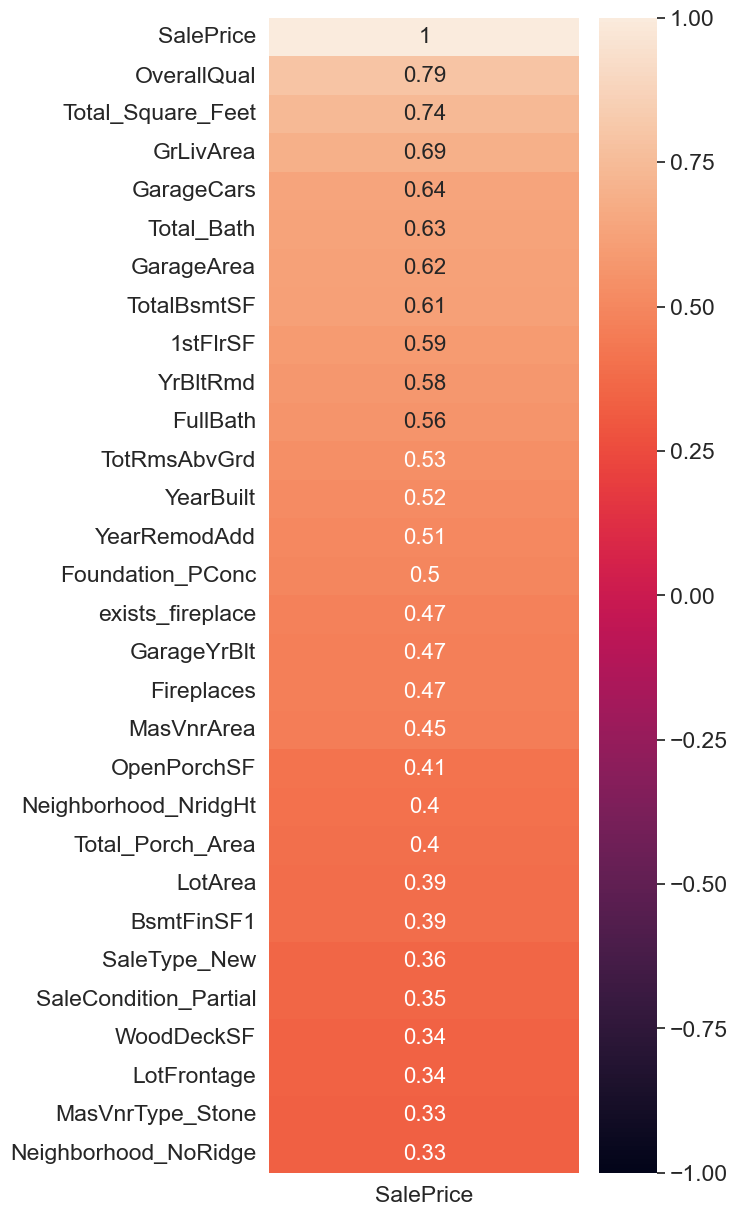

In [21]:
corr_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, annot=True)
sb.set(font_scale=2)

In [22]:
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        best_columns.append(key)
best_columns

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'old_house',
 'KitchenQual',
 'ExterQual']

In [23]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_8912\3427470557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SalePrice_Log1p'] = np.log1p(train.SalePrice)


In [24]:
print(min(train['SalePrice_Log1p']))
print(max(train['SalePrice_Log1p']))

10.460270761075149
13.534474352733596


C:\Users\bhavy\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skew Dist: 0.12134661989685333
Kurtosis Dist: 0.809519155707878


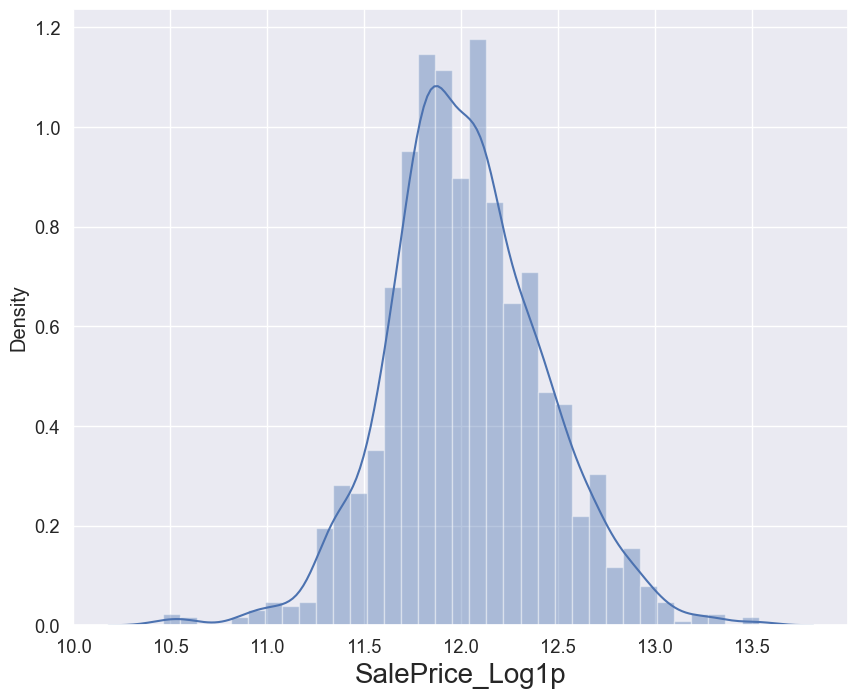

In [25]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['SalePrice_Log1p'])
plt.xlabel('SalePrice_Log1p',fontsize=20)
print('Skew Dist:',train['SalePrice_Log1p'].skew())
print('Kurtosis Dist:',train['SalePrice_Log1p'].kurt())

In [26]:

rbst_scaler=RobustScaler()
train_rbst=rbst_scaler.fit_transform(train)
train_pca=PCA(3).fit_transform(train_rbst)

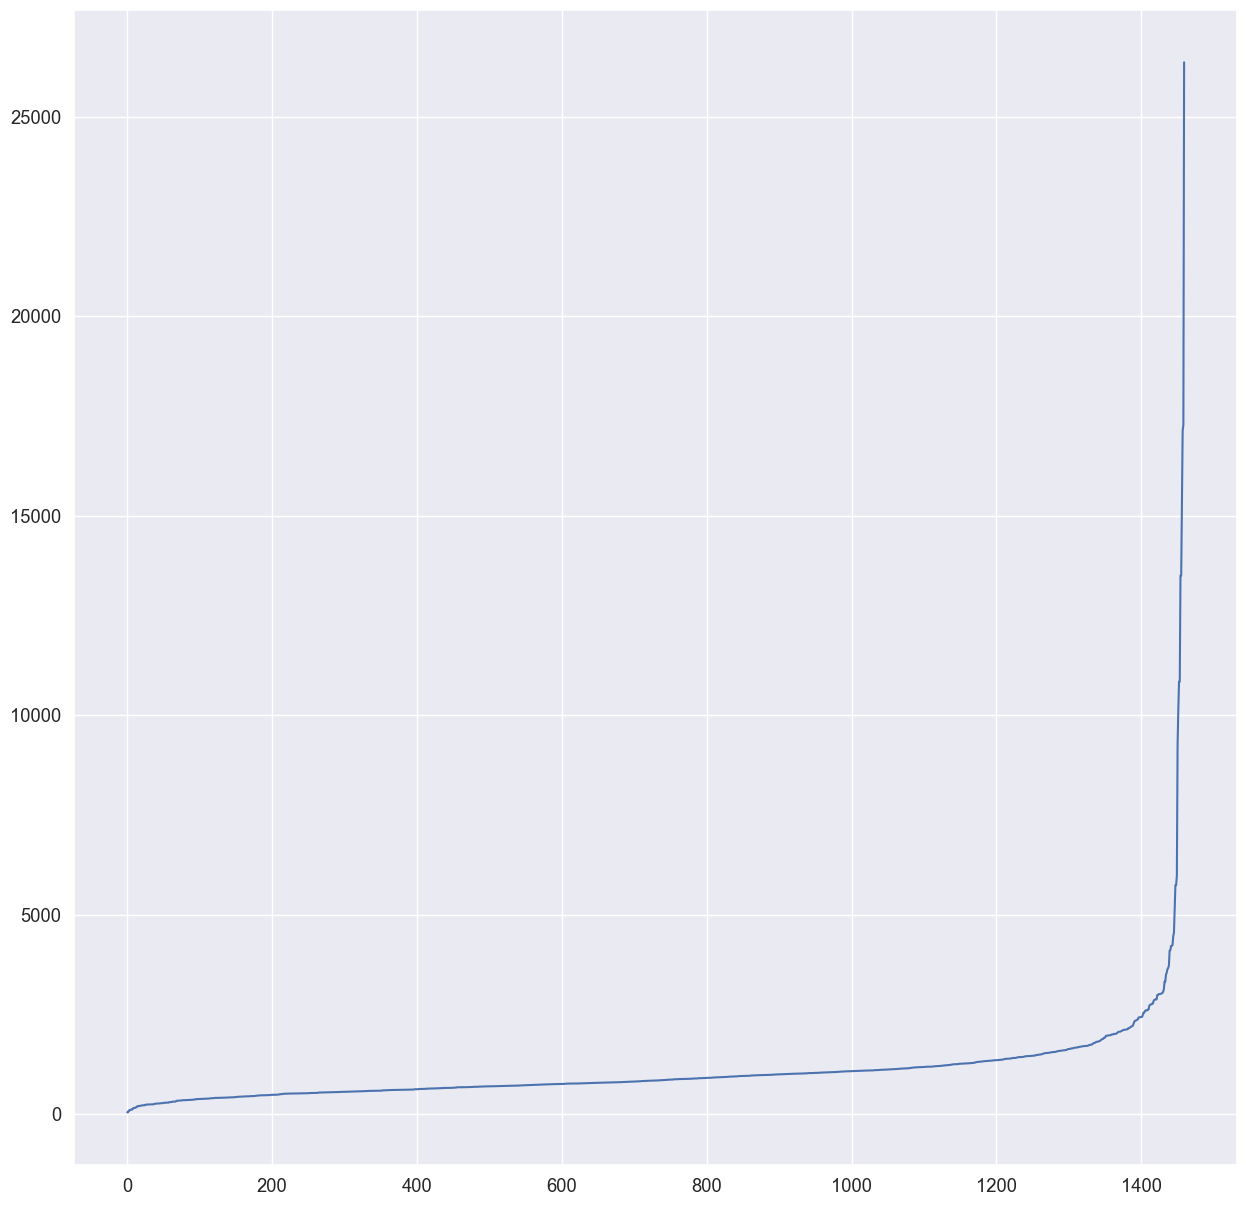

In [27]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,15))
plt.plot(distances)

In [28]:
dbscan = DBSCAN(eps=1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

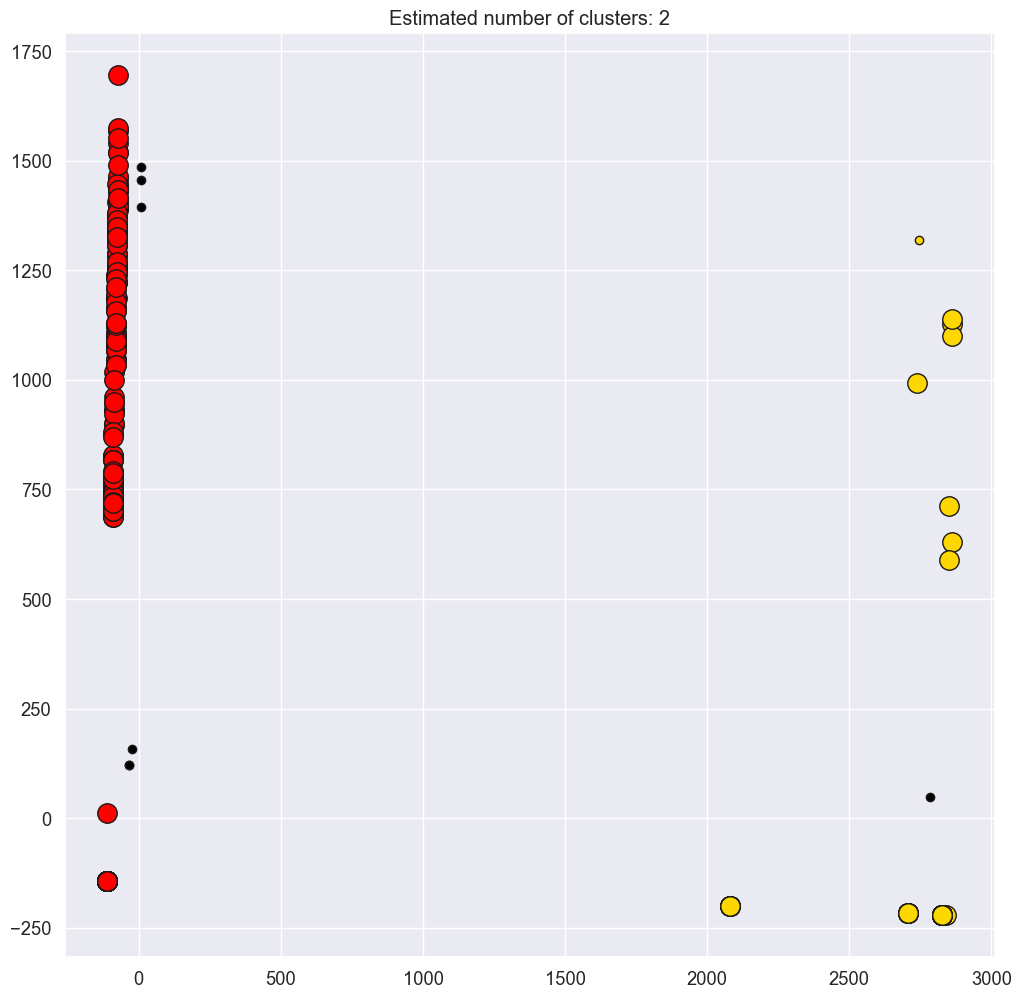

In [29]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [30]:
labels=pd.DataFrame(labels,columns=['Classes'])
print(labels[labels['Classes']==-1])

      Classes
197        -1
810        -1
1170       -1
1182       -1
1298       -1
1386       -1
1423       -1


In [31]:
train=pd.concat([train,labels],axis=1)

In [32]:
train[train.Classes==-1]

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
197    198           7    23.181536  15.851264  0.666716      1         3   
810    811           0    15.102199  13.811205  0.666716      1         3   
1170  1171           8    14.890055  13.755758  0.666716      1         3   
1182  1183           5    22.181037  14.751524  0.666716      1         0   
1298  1299           5    31.456893  18.058234  0.666716      1         2   
1386  1387           5    15.311596  14.898482  0.666716      1         0   
1423  1424           8    14.457078  15.268764  0.666716      1         0   

      LandSlope  OverallQual  OverallCond  ...  SaleType_Oth  SaleType_WD  \
197         0.0            8            3  ...             0            1   
810         0.0            6            5  ...             0            1   
1170        0.0            6            5  ...             0            1   
1182        0.0           10            4  ...             0            1   
1298        0.0           10            4  ...             0            0   
1386        0.0            7            4  ...             0            1   
1423        0.0            6            6  ...             0            1   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
197                       1                      0                     0   
810                       0                      0                     0   
1170                      0                      0                     0   
1182                      1                      0                     0   
1298                      0                      0                     0   
1386                      0                      0                     0   
1423                      0                      0                     1   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  \
197                      0                     0                      0   
810                      0                     1                      0   
1170                     0                     1                      0   
1182                     0                     0                      0   
1298                     0                     0                      1   
1386                     0                     1                      0   
1423                     0                     0                      0   

      SalePrice_Log1p  Classes  
197         12.367345       -1  
810         12.106258       -1  
1170        12.049425       -1  
1182        13.521141       -1  
1298        11.982935       -1  
1386        12.429220       -1  
1423        12.524421       -1  

[7 rows x 234 columns]

In [33]:
train.drop([197,810,1170,1182,1298,1386,1423],axis=0,inplace=True)


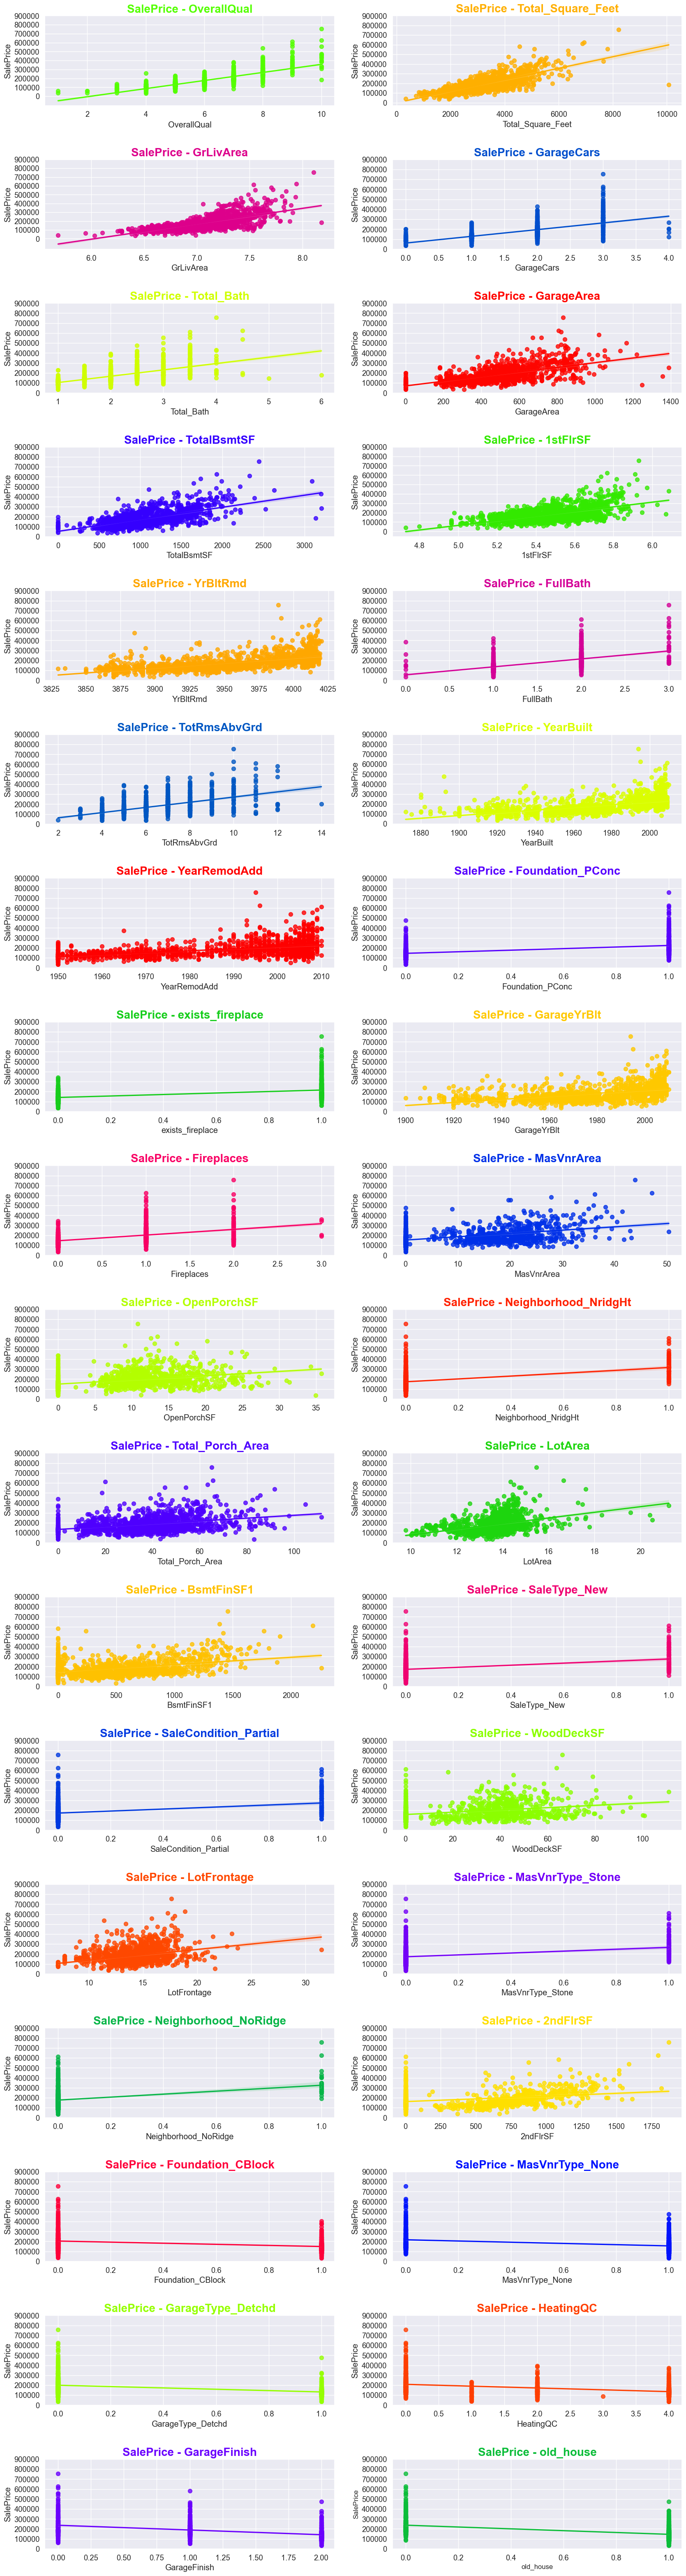

In [34]:

fig, axes = plt.subplots(18, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

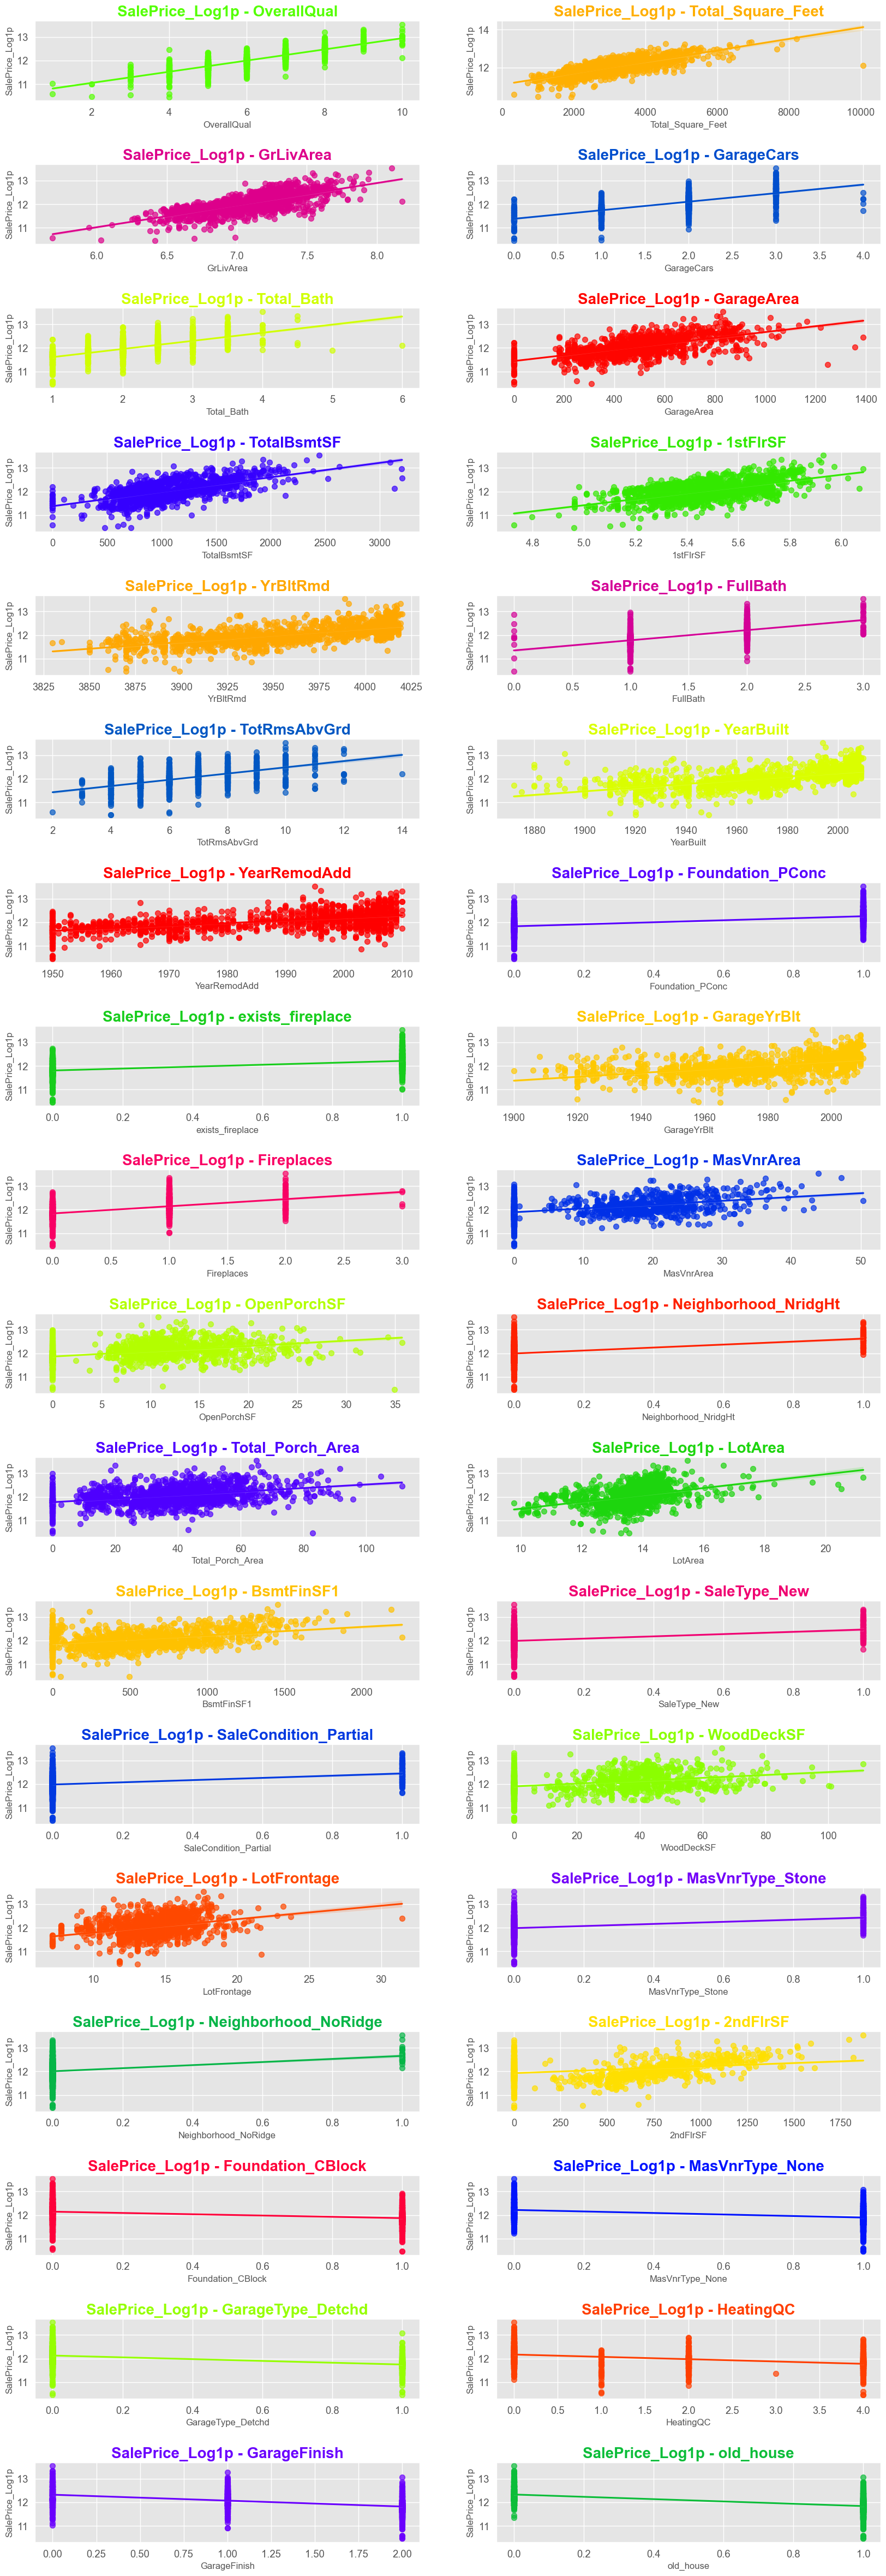

In [35]:
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [36]:
train = train[train.GarageArea * train.GarageCars < 3700]
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

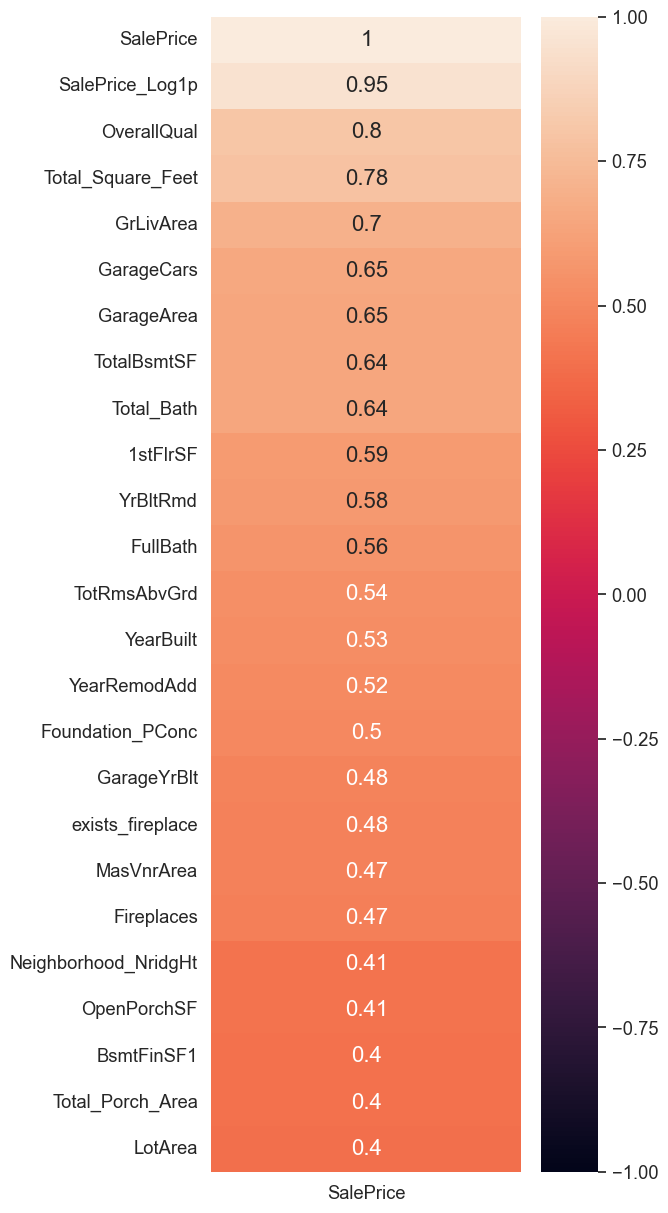

In [37]:

corr1_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(25),annot_kws={"size": 16},vmin=-1, annot=True)
sb.set(font_scale=2)

In [38]:
del test['SalePrice']

In [39]:
X=train.drop(['SalePrice','SalePrice_Log1p','Classes'],axis=1)
y=train.SalePrice_Log1p

In [40]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(X)

In [41]:
X.drop(overfitted_features,axis=1,inplace=True)
test.drop(overfitted_features,axis=1,inplace=True)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_8912\3769908614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(overfitted_features,axis=1,inplace=True)


In [42]:
std_scaler=StandardScaler()
rbst_scaler=RobustScaler()
power_transformer=PowerTransformer()
X_std=std_scaler.fit_transform(X)
X_rbst=rbst_scaler.fit_transform(X)
X_pwr=power_transformer.fit_transform(X)

test_std=std_scaler.transform(test)
test_rbst=rbst_scaler.transform(test)
test_pwr=power_transformer.transform(test)

NameError: name 'PowerTransformer' is not defined

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_std,y,test_size=0.002,random_state=52)


In [ ]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(X_train, y_train)
y_head=lgb_regressor.predict(X_test)


In [ ]:
y_head=pd.DataFrame(y_head,columns=['Predict'])
y_test.reset_index(drop=True,inplace=True)
y_test_y_head=pd.concat([y_test,y_head],axis=1)
y_test_y_head.head()

In [ ]:
test_pred_lgb=lgb_regressor.predict(test_pwr)
test_pred_lgb=pd.DataFrame(test_pred_lgb,columns=['SalePrice'])
test_pred_lgb.SalePrice =np.floor(np.expm1(test_pred_lgb.SalePrice))


In [ ]:
test_pred_lgb.head()

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(X_train, y_train)
y_head=ridgecv_reg.predict(X_test)
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
test_pred_ridge=ridgecv_reg.predict(test_pwr)
test_pred_ridge=pd.DataFrame(test_pred_ridge,columns=['SalePrice'])
test_pred_ridge.SalePrice =np.floor(np.expm1(test_pred_ridge.SalePrice))


In [ ]:
test_pred_ridge.head()

In [ ]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(X_train, y_train)
y_head=gb_reg.predict(X_test)
print('-'*10+'GBR'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
test_pred_gb=gb_reg.predict(test_pwr)
test_pred_gb=pd.DataFrame(test_pred_gb,columns=['SalePrice'])
test_pred_gb.SalePrice =np.floor(np.expm1(test_pred_gb.SalePrice))




In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(X_train, y_train)
y_head=lassocv_reg.predict(X_test)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
test_pred_lasso=lassocv_reg.predict(test_pwr)
test_pred_lasso=pd.DataFrame(test_pred_lasso,columns=['SalePrice'])
test_pred_lasso.SalePrice =np.floor(np.expm1(test_pred_lasso.SalePrice))


In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train, y_train)
y_head=elasticv_reg.predict(X_test)
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
test_pred_elastic=elasticv_reg.predict(test_pwr)
test_pred_elastic=pd.DataFrame(test_pred_elastic,columns=['SalePrice'])
test_pred_elastic.SalePrice =np.floor(np.expm1(test_pred_elastic.SalePrice))


In [ ]:
estimators = [('lgbm', lgb_regressor),
              ('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg)]

stack_reg=StackingRegressor(estimators=estimators,final_estimator=ExtraTreesRegressor(n_estimators=50),n_jobs=-1)
stack_reg.fit(X_train, y_train)
y_head=stack_reg.predict(X_test)
print('-'*10+'StackingRegressor'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
test_pred_stack=stack_reg.predict(test_pwr)
test_pred_stack=pd.DataFrame(test_pred_stack,columns=['SalePrice'])
test_pred_stack.SalePrice =np.floor(np.expm1(test_pred_stack.SalePrice))


In [ ]:
final_pred=(test_pred_stack*0.1665)+(test_pred_lgb*0.678)+(test_pred_gb*0.1665)
final_pred.head()

In [ ]:
pd.DataFrame(final_pred, columns=['SalePrice']).to_csv('C:/Comp1/predictions.csv', index=False)